<h2 id="top" style="font-family: Tahoma, sans-serif">MTA Ridership On New York City Map</h2>
<h5><i>By Kyoosik Kim</i></h5>
<p><br/>qshickkim@gmail.com<br/><a href="#" style="color: gray">Homepage</a></p>
<hr>
<h3 style="font-family:Tahoma, sans-serif;">Introduction</h3>
<div style="font-family:sans-serif; font-size: 15px; text-align: justify">
  <p style="text-align: inherit">This project is to visualize MTA ridership on the map of New York City for answers to the question <i>"What stations are the busiest? And why?"</i>. In the course of the project, I will encompass various aspects of data science from data munging, data visualizaition, to data analysis. The base data set is <a href="https://s3.amazonaws.com/content.udacity-data.com/courses/ud359/turnstile_data_master_with_weather.csv">NYC turnstile data</a> which can be found in the Udacity courses <a href="https://www.udacity.com/course/intro-to-data-science--ud359">Intro to Data Science</a>. Additionally, I will utilize two other external data sets; <a href="https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49/data">NYC Subway Station</a> and <a href="http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls
">MTA Remote Unit Code</a>. The location information from the NYC subway station is to be added onto the other data set. After that, the combined data set is merged with the base data set to provide the ridership data by station and its individual physical location. The final outcome will be the map of New York City with MTA ridership as dots in the size of popularity. The sections are as below <i>(click the section title to jump to)</i>.</p>
  <ol>
    <li><a href="#prep" style="color: black">Data Preparation</a></li>
    <li><a href="#visual" style="color: black">Data Visualization</a></li>
    <li><a href="#analysis" style="color: black">Analysis and Conclusion</a></li>
  </ol>
Before moving on, I would like to recommend to check some other visualization of my work like <a href="https://github.com/Q-shick/Intro-to-Data-Science/blob/master/Data%20Visualization.ipynb">MTA Ridership by hour-day-month</a> and <a href="#">Interactive Visualization on Tableau</a>.
</div>

<hr>
<h3 id="prep" style="font-family:Tahoma, sans-serif;">Data Preparation</h3>
<p style="font-family:sans-serif; font-size: 15px">&bull; Import Libraries and Set File Paths</p>

In [18]:
# manipulate data and data frames
import numpy as np
import pandas as pd
# match station names
import string
from fuzzywuzzy import fuzz
# geographical data
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
# visualization
from IPython.display import IFrame
import matplotlib.pyplot as plt
%matplotlib inline
# do not show warnings
import warnings
warnings.filterwarnings("ignore")

# file paths
turnstile_base = './Data/turnstile_data_master_with_weather.csv'
remote_unit = './Data/Remote-Booth-Station.csv'
station_position = './Data/DOITT_SUBWAY_STATION_01_13SEPT2010.csv'
correct_station_name = './Data/correct_station_name.txt'
nyc_map_data = './Data/Borough Boundaries/geo_export_1e1c40bf-0d50-4899-ab1d-0056152c3698.shp'
mta_map = "./Data/The-New-York-City-Subway-Unique-Geographically-Accurate-Nyc-Subway-Map.jpg"

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Read Base Data</p>

In [19]:
# base data set
master_df = pd.read_csv(turnstile_base)
master_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Define Functions</p>

In [20]:
"""
The station names of the two external data sets are different in alphabet, length, and so on.
The functions below are mostly to match the station names before merging the data sets.
"""

# get rid of ordinal expressions
def process_st_number(words):
    ordinal = ["st", "nd", "rd", "th"]
    result = ""
    words = words.split(" ")
    
    for word in words:
        if word[0].isdigit():
            for match in ordinal:            
                word = word.replace(match, "")
        
        result = result + " " + word
    # ex. 123rd -> 123
    return result.strip()

# move number part before character
def swap_station_name(name):
    # take care of "name (123)" cases
    name = name.replace("(", "- ")
    name = name.replace(")", "")
    # delete ordinal and make it uppercase
    name = process_st_number(name)
    name = name.replace(" - ", "-").upper()
    split = name.split("-")
    
    # cases that have '-' symbol
    if len(split) == 2:
        if (not split[0][0].isdigit()) and (split[1][0].isdigit()):
            return split[1] + "-" + split[0]
        else:
            return split[0] + "-" + split[1]
    # ex. street-123 -> 123-street
    return name

# make the two station lists in accordance
def process_station_name(name):
    name = swap_station_name(name)
    
    # limit the length to 15 characters long
    if len(name) >= 15:
        if name[13] is " ":
            return name[0:13] # special case
        else:
            return name[0:15]
        
    return name

# find the same or the most similar station name
def compare_station_name(name, match_list):
    # just return if same
    if (name in match_list):
        return name
    
    # fuzzywuzzy return a score ranged 0~100
    highest = 0
    similar_name = ""
    for match in match_list:
        score = fuzz.ratio(name, match)
        if score > highest:
            highest = score
            similar_name = match
            
    return similar_name

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Read and Process Data Sets in Format</p>

In [21]:
# read Remote Unit data set and process it
remote_unit_df = pd.read_csv(remote_unit, usecols = ['Remote', 'Station'])
remote_unit_df.drop_duplicates(subset = 'Remote', keep = 'first', inplace = True)
remote_unit_df.columns = ['UNIT', 'station']
remote_unit_df['station'] = remote_unit_df['station'].apply(
    lambda s : swap_station_name(s))

# read Station Position data set and process it
station_position_df = pd.read_csv(station_position, usecols = ['NAME', 'the_geom'])
station_position_df.drop_duplicates(subset = 'NAME', keep = 'first', inplace = True)
station_position_df.columns = ['station', 'position']
station_position_df['station'] = station_position_df['station'].apply(
    lambda s : process_station_name(s))

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Process Data Sets for Detailed Merge</p>

In [22]:
"""
Even after processing station names with the functions, there are still discrepancies.
This is because the differences are out of pattern that the function can catch.
Part of the job is done manually, instread of writing more functions for each case.
"""

# station_temp is from Remote Unit data set
station_position_df['station_temp'] = station_position_df['station'].apply(
    lambda name : compare_station_name(name, list(remote_unit_df['station'])))

# compare and find different names
diff = []
for i in range(0, len(station_position_df)):
    if (station_position_df['station'].iloc[i] is not 
            station_position_df['station_temp'].iloc[i]):
        diff.append(i)

# look through names to find the ones that are totally different
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    display((station_position_df.iloc[diff]).sort_values('station')[0:10])

,station,position,station_temp
13,104-102 STS,POINT (-73.84443500029684 40.69516599823373),104 ST
6,110 ST-CATHEDRA,POINT (-73.95806670661364 40.800581558114956),110 ST-CATHEDRL
159,110 ST-CENTRAL,POINT (-73.95182200176913 40.79907499977324),110 ST-CATHEDRL
140,138 ST-GRAND CO,POINT (-73.92984899935611 40.81322399958908),138 ST-GR CONC
260,148 ST-HARLEM,POINT (-73.93647000005559 40.82388000080457),148 ST-LENOX
46,149 ST-GRAND CO,POINT (-73.9273847542618 40.81830344372315),149 ST-GR CONC
106,15 ST-PROSPECT,POINT (-73.97973580592873 40.66003568810021),15 ST-PROSPECT
411,163 ST-AMSTERDA,POINT (-73.93989200188344 40.83601299923096),163 ST-AMSTERDM
57,168 ST,POINT (-73.93956099985425 40.84071899990795),18 ST
20,174-175 STS,POINT (-73.91013600050078 40.84589999983414),174-175 ST


<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Fine Tuning before Merging</p>

In [23]:
# bring the list written manually
correct_station_name_df = pd.read_csv(correct_station_name)

# correct the names
for row, index in correct_station_name_df.iterrows():
    station_position_df['station_temp'][index[0]] = index[1]
    
# match stations names for two data sets
station_position_df['station'] = station_position_df['station_temp']
station_position_df.drop('station_temp', axis = 1, inplace = True)

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Merge All Data Sets</p>

In [24]:
"""
Now, the two data sets have identical station names to be ready for merge.
By merging them, Remote Unit data set is to have physical positions for each of stations.
And then, the base data set is to have station names and their positions 
by being merged with Remote Unit data set.
"""

# merge on station names
remote_unit_df = pd.merge(remote_unit_df, station_position_df, on = 'station')
# merge on Unit
master_df = pd.merge(master_df, remote_unit_df, on = 'UNIT')
# select station and turnstile columns for visualization
entry_exit_by_station = master_df.groupby(
    ['station', 'position'])['ENTRIESn_hourly', 'EXITSn_hourly'].mean()
entry_exit_by_station_df = pd.DataFrame(entry_exit_by_station)
entry_exit_by_station_df.drop_duplicates(inplace = True)
entry_exit_by_station_df.reset_index(level = ['station', 'position'], inplace = True)
entry_exit_by_station_df.columns = ['station', 'position', 'entry_mean', 'exit_mean']
entry_exit_by_station_df.head()

,station,position,entry_mean,exit_mean
0,1 AVE,POINT (-73.98168087489128 40.73097497580066),3295.478495,3594.618280
1,103 ST,POINT (-73.96837899960818 40.799446000334825),1630.593002,1214.834254
2,103 ST-CORONA,POINT (-73.86269999830412 40.749865000555545),2735.220430,2116.392473
3,104 ST,POINT (-73.83768300060997 40.681711001091195),367.005882,299.800000
4,110 ST,POINT (-73.94424999687163 40.795020000113105),1713.263441,1484.026882


<hr>
<h3 id="visual" style="font-family:Tahoma, sans-serif;">Data Visualization</h3>
<p style="font-family:sans-serif; font-size: 15px">&bull; Process Geographical Positions</p>

In [25]:
"""
GeoPandas requires a certain geographical format.
Since the position is simply a string, it should be processed.
"""

def process_position(pos):
    # drop string 'POINT', '(' and ')'
    pos = pos.translate({ord(x) : y for (x, y) in zip("()", [None, None])})
    pos = pos.split(" ")
    # Point from GeoSeries
    return Point(float(pos[1]), float(pos[2]))

entry_exit_by_station_df['position'] = entry_exit_by_station_df['position'].apply(
    lambda pos : process_position(pos))

print(type(entry_exit_by_station_df['position'][0]))

<class 'shapely.geometry.point.Point'>


<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Read and Visualize the Geographical Data <a href="https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm">(NYC map source)</a></p>

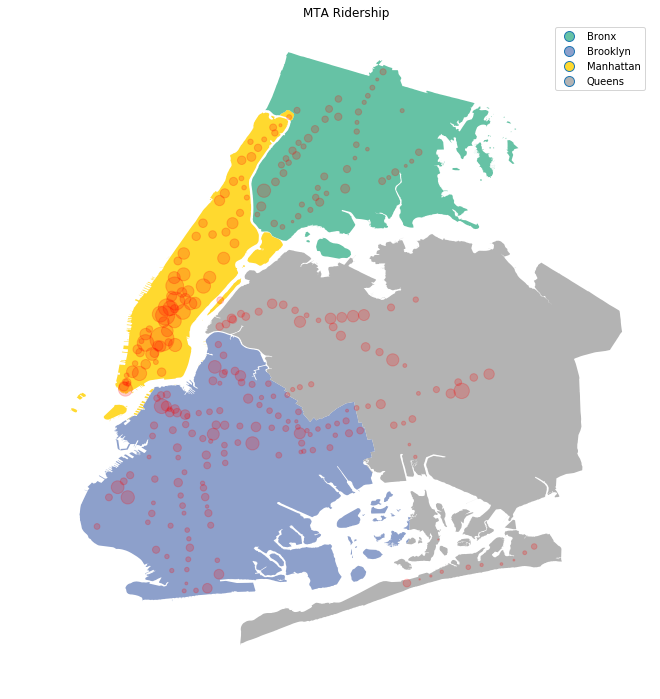

In [26]:
"""
NYC map can be drawn by utilizing geographical data frames.
MTA stations is drawn on the NYC map as dots at the exact position in size of popularity.
"""

# create geographical data frames
nyc_map = gpd.read_file(nyc_map_data)
nyc_map = nyc_map[nyc_map['boro_name'] != 'Staten Island'] # no data in Staten Island
station_gs = GeoSeries(entry_exit_by_station_df['position'])

# popularity of a station is measured by adding hourly entries and exits
entry_exit = pd.Series((entry_exit_by_station_df['entry_mean'] + 
                        entry_exit_by_station_df['exit_mean']))
turnstile_marker_size_1 = entry_exit/10 # divided by 10 for reasonable marker size
turnstile_marker_size_2 = (entry_exit - 5000)/10 # only for stations with over 5000 turnstiles

# plot NYC map and geographical turnstile data
fig, ax = plt.subplots(figsize = (12, 12))
nyc_map.plot(ax = ax, cmap = 'Set2', column = 'boro_name', legend = True)
station_gs.plot(ax = ax, marker='.', color = 'red', 
                markersize = turnstile_marker_size_1, alpha = 1/5)

ax.set_axis_off()
ax.set_title("MTA Ridership")

plt.show()

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; MTA Map for Comparison <a href="http://catholicandlovinit.com/geographically-accurate-nyc-subway-map/the-new-york-city-subway-unique-geographically-accurate-nyc-subway-map/">(image source)</a></p>

In [27]:
# actual MTA lines on NYC map
IFrame(mta_map, width = 500, height = 500)

<hr>
<br/>
<p style="font-family:sans-serif; font-size: 15px">&bull; Popular MTA stations</p>

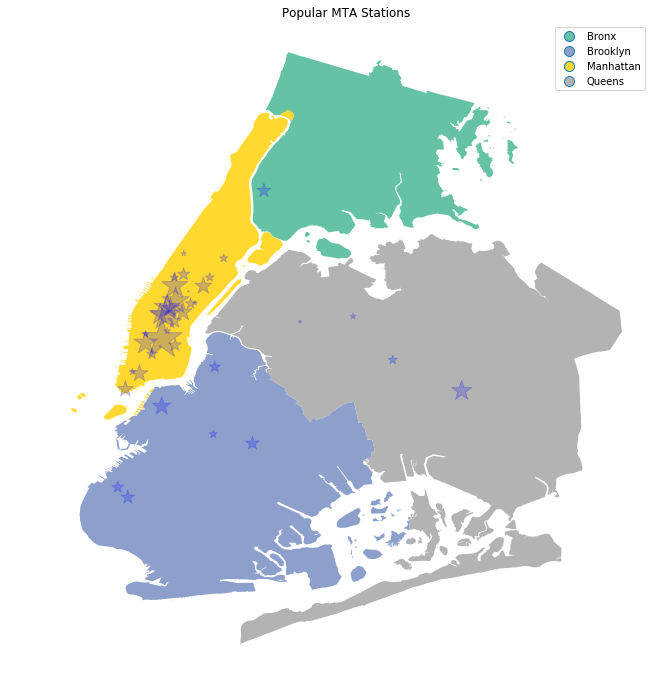

<Top 10 Busiest Stations>
 station     turnstile
 14 ST-UNION SQ  23174.909465
34 ST-HERALD SQ  14790.455224
  47-50 ST-ROCK  13079.695652
 59 ST-COLUMBUS  12645.709804
 42 ST-TIMES SQ  12127.096692
 W 4 ST-WASH SQ  11078.175532
 34 ST-PENN STA  10043.833545
 JAMAICA CENTER   9448.112195
42 ST-BRYANT PK   8766.276699
42 ST-GRD CNTRL   8764.510336


In [28]:
# stations with over 5000 hourly turnstiles
busy_station_df = pd.DataFrame({'station': entry_exit_by_station_df['station'], 
                                'turnstile': entry_exit})
busy_station_df = busy_station_df[busy_station_df['turnstile'] >= 5000]

# plot NYC map and popular stations as stars
fig, ax = plt.subplots(figsize = (12, 12))
nyc_map.plot(ax = ax, cmap = 'Set2', column = 'boro_name', legend = True)
station_gs.plot(ax = ax, marker='*', color = 'blue', 
                markersize = turnstile_marker_size_2, alpha = 1/5)

ax.set_axis_off()
ax.set_title("Popular MTA Stations")

plt.show()
print("<Top 10 Busiest Stations>\n", 
      (busy_station_df.sort_values(by = 'turnstile', ascending = False).head(10))
      .to_string(index=False))

<hr>
<h3 id="analysis" style="font-family:Tahoma, sans-serif;">Analysis</h3>
<div style="font-family:sans-serif; font-size: 15px; text-align: justify"><p style="text-align: justify">As seen in the plot and the image, the position data seems to be accurate in that the dots correspond to the actual layout of MTA lines on the map. The size of a dot implies popularity of the station, that is, the bigger the more people use it.</p>
  <ol>
    <li style="padding: 10px, 0, 0, 10px"><strong>Mahattan is busy</strong>: As expected, so many large dots are spotted in Manhattan, especially in the lower area where a lot of businesses are located. That area is also where multiple MTA lines are crossed so people can transfer.</li>
    <li style="padding: 10px, 0, 0, 10px"><strong>The rest also have busy stations</strong>: It is said that many of the residents in New York City commute from Brooklyn, Bronx, and Queens to Manhattan. This would be probably why there are some stars in the neighborhoods even if most of the stars are found in Manhattan when a star means a station with over 5000 mean turnstile times. The sole star in <strong>Bronx</strong> is <i>'161 Street Yankee Stadium'</i> station, which naturally makes sense. Next in <strong>Queens</strong>, the biggest star slightly to the west from the center is <i>'Jamaica Center'</i> station where people from JFK airport can easily transfer to several subway or train lines, or buses. Lastly, the big star in east-north <strong>Brooklyn</strong> is <i>'Borough Hall'</i> station. This is not surprising because it is now common that a lot of people commute from Brooklyn to Manhattan to avoid high cost of living and Borough Hall station is one of the closest stations to Manhattan, right over the Brooklyn bridge. Also, there are universities, government buildings, and businesses near the station itself.</li>
  </ol>
</div>

<hr>
<h3 style="font-family:Tahoma, sans-serif;">Conclusion</h3>
<p style="font-family:sans-serif; font-size: 15px; text-align: justify">Although it is widely known that Manhattan area is busy, the visualization was still very useful to understand how relatively busy Manhattan is compared with other areas. Also, it helped me discover another fact that there are quite popular MTA stations in other areas than Manhattan. This led to another question like why this station in Queens is busy and what neighborhood there is. To further the research, I can look into population data, income, or such data in New York City to better analyze it.</p>

<hr>
<h3 style="font-family:Tahoma, sans-serif;">Reference</h3>
<p style="font-family: sans-serif; font-size: 15px; text-align: justify">Below are the links to websites where I found useful information excluding what were already mentioned above.</p>
<ul>
  <li>Geo Pandas 1: <a href="http://geopandas.org/index.html">Offical Website</a></li>
  <li>Geo Pandas 2: <a href="https://geohackweek.github.io/vector/04-geopandas-intro/">Useful Tutorial</a></li>
  <li>Understanding of MTA Data: <a href="https://data.ny.gov/api/views/ekwu-khcy/files/e35d46bb-d988-44c5-a170-8736c1c773af?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf">Data Dictionary (download pdf)</a></li>
</ul>
<p style="width: 100%; text-align: right"><a href="#top">Go Back To Top</a>&nbsp;&nbsp;</p>